# Misc

In [1]:
using IJulia
using DifferentialEquations
using DynamicalSystems
using Plots, DataFrames
using Random
using LinearAlgebra

function generate_symmetric_matrix(N::Int)
    # Create an upper triangular matrix including the diagonal
    upper_tri = triu(rand(Bool, N, N), 1) - triu(rand(Bool, N, N), 1)
    
    # Reflect the upper triangular part to the lower triangular part
    symmetric_matrix = upper_tri .| upper_tri'
    
    # Convert to Float64
    symmetric_matrix = Float64.(symmetric_matrix)
    
    return symmetric_matrix
end

function load_cnf(file_name)
    c = Nothing
    open(file_name) do file
        for (idx, line) in enumerate(eachline(file))
            if idx == 1
                N = parse(Int32, split(line, " ")[3])
                M = parse(Int32, split(line, " ")[4])
                c = zeros(M,N)
            else
                variables = split(line, " ")
                for var_str in variables
                    var = parse(Int32, var_str)
                    if var != 0
                        if var > 0
                            c[idx-1, var] = 1
                        elseif var < 0
                            c[idx-1, -var] = -1
                        end
                    end
                end
            end
        end
    end
    return c
end

function number_of_satisfied_clauses(state, c)
    M, N = size(c)
    result = 0
    for m in 1:M
        satisfied = 0
        for j in 1:N
            if c[m,j] == state[j]
                satisfied = 1
                break
            end
        end
        result += satisfied
    end
    return result
end

function is_satisfied(spin_config, c)
    function check_clause(row, state)
        for (index,elem) in enumerate(row)
            if elem == state[index]
                return true
            end
        end
    end

    incorrect_flag = false
    for clause in eachrow(c)
        if check_clause(clause, spin_config) != true
            incorrect_flag = true
            break
        end
    end

    if incorrect_flag
        return false
    end
    return true
end

function read_Ising_data(file_path)
    # Initialize variables
    result_vector = []
    matrix = []

    # Open the file and read its contents
    file = open(file_path, "r")
    contents = readlines(file)

    # Extract the result vector from the third line
    result_vector_str = contents[3]
    # Remove the brackets and split the string into individual elements
    result_vector_str = replace(result_vector_str, r"[\[\]]" => "")
    result_vector_str = split(result_vector_str, ",")

    # Convert the elements to floats and store them in the result vector
    for num_str in result_vector_str
        push!(result_vector, parse(Float64, num_str))
    end

    # Determine the size of the matrix
    N = length(result_vector)

    # Initialize the matrix with zeros
    matrix = zeros(Float64, N, N)

    # Extract the matrix from the lines after the fifth line
    for i in 6:length(contents)
        line = contents[i]
        # Skip empty lines
        if line != "\n" && line != "[\n" && line != "]\n"
            # Remove the brackets and split the string into individual rows
            line = replace(line, "[" => "")
            line = replace(line, "]," => "")
            line = replace(line, "]" => "")
            # Convert the elements to floats and store them in the matrix
            row_str = split(line, ",")
            if row_str != [""]
                row = [parse(Float64, num_str) for num_str in row_str]
                matrix[i-5, :] = row
            end
        end
    end

    # Close the file
    close(file)

    return (N, result_vector, matrix)
end

function write_ISING_to_file(filename::String, N::Int, V::Vector{Float64}, M::Matrix{Float64})
    open(filename, "w") do file
        # Write N
        println(file, N)
        
        # Write an empty line
        println(file)
        
        # Write the vector V
        println(file, V)
        
        # Write an empty line
        println(file)
        
        # Write the matrix M in the desired format
        println(file, "[")
        for i in 1:size(M, 1)
            row = M[i, :]
            println(file, "  ", row, ifelse(i == size(M, 1), "", ","))
        end
        println(file, "]")
    end
end


write_ISING_to_file (generic function with 1 method)

In [8]:
using JuMP
using SCIP

# Function to find the minimum scalar product for each row in J
function get_hmin(J::Matrix{Float64})
    N = size(J, 1)
    h_min_values = Vector{Float64}(undef, N)

    for row in 1:N
        # Create a model with the SCIP solver
        model = Model(SCIP.Optimizer)

        # Define variables, each can be +1 or -1
        @variable(model, x[i=1:N], Bin)

        # Define the objective function to minimize for the current row
        @objective(model, Min, sum(J[row, i] * (2x[i] - 1) for i in 1:N))

        # Solve the model
        optimize!(model)

        # Get the minimum scalar product h for the current row
        h_min_values[row] = objective_value(model)
    end

    return h_min_values
end

# Function to find the maximum scalar product for each row in J
function get_hmax(J::Matrix{Float64})
    N = size(J, 1)
    h_max_values = Vector{Float64}(undef, N)

    for row in 1:N
        # Create a model with the SCIP solver
        model = Model(SCIP.Optimizer)

        # Define variables, each can be +1 or -1
        @variable(model, x[i=1:N], Bin)

        # Define the objective function to minimize for the current row
        @objective(model, Max, sum(J[row, i] * (2x[i] - 1) for i in 1:N))

        # Solve the model
        optimize!(model)

        # Get the minimum scalar product h for the current row
        h_max_values[row] = objective_value(model)
    end

    return h_max_values
end

get_hmax (generic function with 1 method)

# Loading problem, and defining parameters

In [5]:
#file_path = "ISING_problems/genport_1.dat"
file_path = "ISING_problems/pme_ISING_N20_1.dat"
(N, B, J) = read_Ising_data(file_path);

### Generating random problem

Weights of $J$ should be $+1$ or $-1$ divided by $\sqrt{N}$

$ \therefore \frac{H}{N} \approx -0.7$ (at the $N \rightarrow \infty$ limt spin glass theory)

In [19]:
file_path_base = "ISING_problems/pme_ISING"
N = 20
V = 2*rand(N) - ones(N)
M = generate_symmetric_matrix(N) * (1/sqrt(N))
write_ISING_to_file(file_path_base*"_N"*string(N)*"_5.dat", N, V, M)

# Regular CAC

## The update rule

$$
\frac{dx_i}{dt} = (p-1)x_i -x_i^3 -e_i \sum_j J_{ij}x_j
$$

$$
\frac{de_i}{dt} = - \beta e_i \left( x_i^2 - \alpha \right)
$$

In [23]:
function CIMCAC_rule!(du, u, params, t)
    p = params[1]
    alpha = params[2]
    beta = params[3]
    N = params[4]
    J = params[5]

    x = u[1:N]
    e = u[N+1:2N]

    for i in 1:N
        du[i] = (p-1)*x[i]-x[i]^3 - e[i] * sum(J[i, j]*x[j] for j in 1:N)
        du[i+N] = -beta*e[i]*(x[i]^2 - alpha)
    end
end

CIMCAC_rule! (generic function with 1 method)

## Simulation & plotting

In [24]:
# define problem and run simulation
params = (1.1, 0.99, 0.20, N, J)     # (p, a, b, N, J)
tspan = (0.0,150.0)

# initial condition(s)
u0 = 1.05*(2*rand(2*N)-ones(2*N))   # This is x(t=0)
u0[N+1:2*N] = ones(N);              # This is e(t=0)

#p, beta, alpha, N J
prob = ODEProblem(CIMCAC_rule!, u0, tspan, params)
sol = solve(prob, Tsit5());

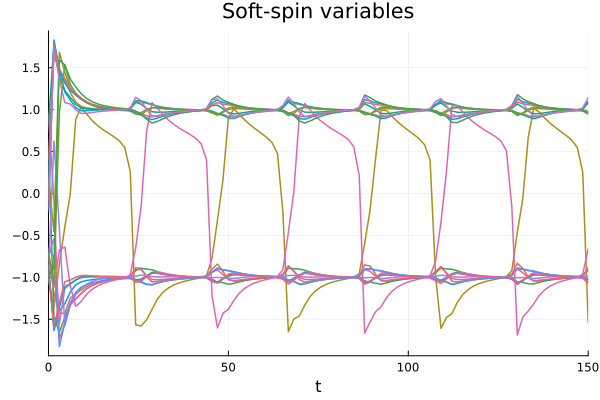

In [42]:
plot(sol, idxs=1:N, plotdensity=100, lw=1.5, title="Soft-spin variables", legend=false)

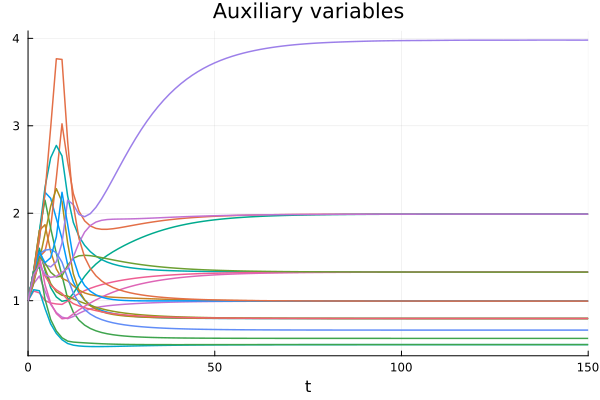

In [26]:
plot(sol, idxs=(N+1):2N, plotdensity=100, lw=1.5, title="Auxiliary variables", legend=false)

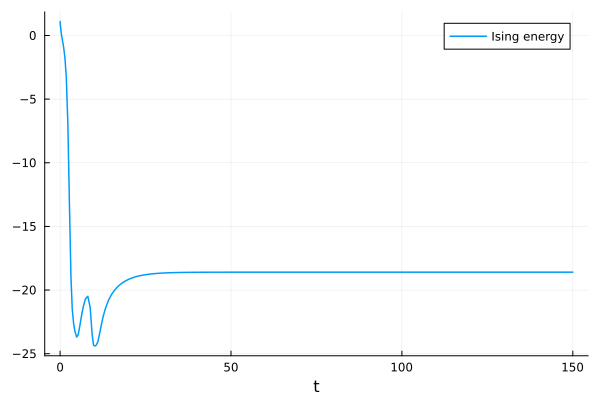

In [25]:
plot(sol.t, [ x_t[1:N]'*(J * x_t[1:N]) for x_t in sol.u], label="Ising energy", lw=1.5, xlabel="t")

# Algo 2

## The update rule

### EoM:
$$
\frac{dx_i}{dt} = a F(x_i) - e_i h_i
$$

$$
\frac{de_i}{dt} = e_i K_i
$$

where
$$K_i = 1-\text{tanh}(h_i) x_i$$
alternative
$$K_i = 1-\text{tanh}(e_i  h_i) x_i $$

In [45]:
function F(x_i, p)
    return (p-1)*x_i-x_i^3
end

function ALGO2_rule!(du, u, params, t)
    p = params[1]
    a = params[2]
    b = params[3]
    N = params[4]
    J = params[5]
b
    x = u[1:N]
    e = u[N+1:2N]

    h = [sum(J[i, j]*x[j] for j in 1:N) for i in 1:N]
    K = [1-tanh(h[i])*x[i] for i in 1:N]
    
    for i in 1:N
        du[i]   = a * F(x[i], p) - e[i] * h[i]
        du[i+N] = e[i]*K[i]
    end
end

ALGO2_rule! (generic function with 1 method)

## Simulation & plotting

In [47]:
# initial condition(s)
u0 = 1.05*(2*rand(2*N)-ones(2*N))   # This is x(t=0)
u0[N+1:2*N] = ones(N);              # This is e(t=0)

# define problem and run simulation
h = [sum(J[i, j]*u0[j] for j in 1:N) for i in 1:N]
params = (1.9, 0.99, 0.1, N, J)     # (p, a, b, N, J)
tspan = (0.0,1.0)

#p, beta, alpha, N J
prob = ODEProblem(ALGO2_rule!, u0, tspan, params)
sol = solve(prob, Tsit5());

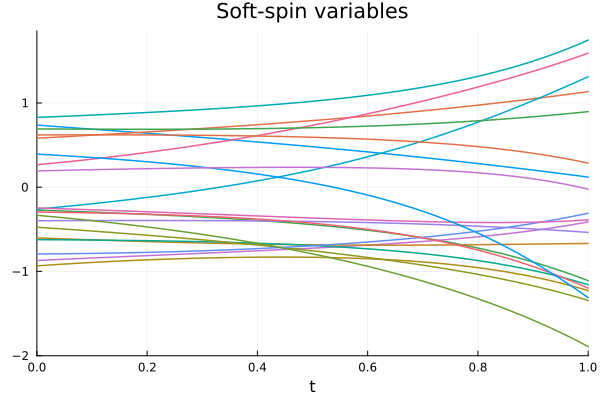

In [48]:
plot(sol, idxs=1:N, plotdensity=100, lw=1.5, title="Soft-spin variables", legend=false)

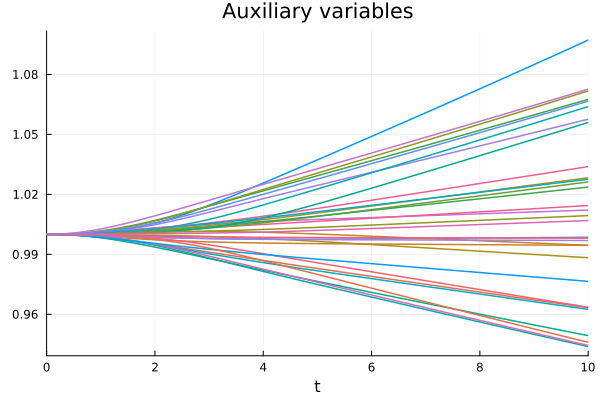

In [62]:
plot(sol, idxs=(N+1):2N, plotdensity=100, lw=1.5, title="Auxiliary variables", legend=false)

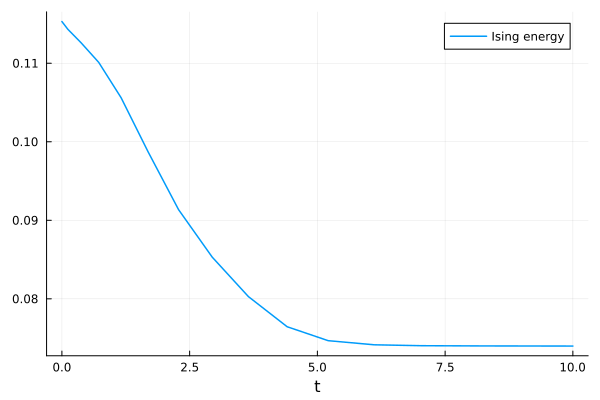

In [63]:
plot(sol.t, [ x_t[1:N]'*(J * x_t[1:N]) for x_t in sol.u], label="Ising energy", lw=1.5, xlabel="t")

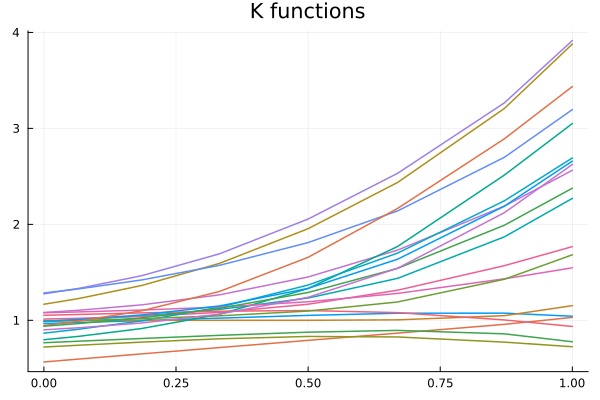

In [37]:
# Preallocate the array for K
K_values = zeros(length(sol.t), N)

# Compute K for each time instance
for (i, u) in enumerate(sol.u)
    x = u[1:N]
    h = [sum(J[i, j] * x[j] for j in 1:N) for i in 1:N]
    # K ALGO2
    K = [1 - tanh(h[i]) * x[i] for i in 1:N]    
    K_values[i, :] = K
end

# Plot each component of K over time
p = plot()
for i in 1:N
    plot!(p, sol.t, K_values[:, i], label="K$i", lw=1.5, legend=false, title="K functions")
end

# Show the plot
display(p)

# Algo 2.5

## Update rule

Memory supression for Algo2

### EoM:
$$
\frac{dx_i}{dt} = a F(x_i) - e_i h_i
$$

$$
\frac{de_i}{dt} = e_i \left[-\lambda \ln\left( \frac{e_i(t)}{e_i(0)} \right) +K_i \right]
$$

In [29]:
function F(x_i, p)
    return (p-1)*x_i-x_i^3
end

function ALGO25_rule!(du, u, params, t)
    p = params[1]
    a = params[2]
    b = params[3]
    N = params[4]
    J = params[5]
    lambda = params[6]

    x = u[1:N]
    e = u[N+1:2N]

    h = [sum(J[i, j]*x[j] for j in 1:N) for i in 1:N]
    K = [1-tanh(h[i])*x[i] for i in 1:N]
    
    for i in 1:N
        du[i]   = a * F(x[i], p) - e[i] * h[i]
        du[i+N] = e[i]*(K[i] - lambda*log(e[i]))
    end
end

ALGO25_rule! (generic function with 1 method)

## Simulation & plotting

In [33]:
# initial condition(s)
u0 = 1.05*(2*rand(2*N)-ones(2*N))   # This is x(t=0)
u0[N+1:2*N] = ones(N);              # This is e(t=0)

# define problem and run simulation
h = [sum(J[i, j]*u0[j] for j in 1:N) for i in 1:N]
params = (1.9, 0.99, 0.1, N, J, 0.0)     # (p, a, b, N, J, lambda)
tspan = (0.0,1.0)

#p, beta, alpha, N J
prob = ODEProblem(ALGO25_rule!, u0, tspan, params)
sol = solve(prob, Tsit5());

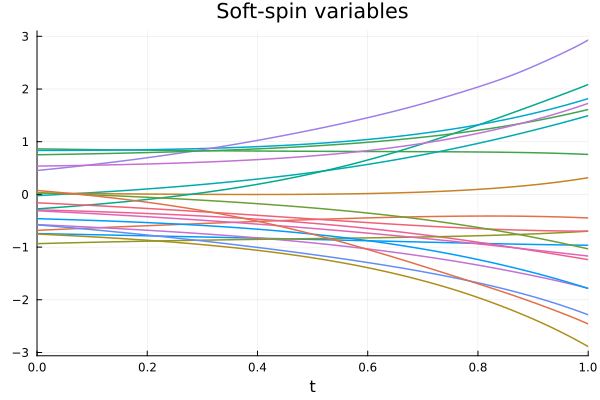

In [34]:
plot(sol, idxs=1:N, plotdensity=100, lw=1.5, title="Soft-spin variables", legend=false)

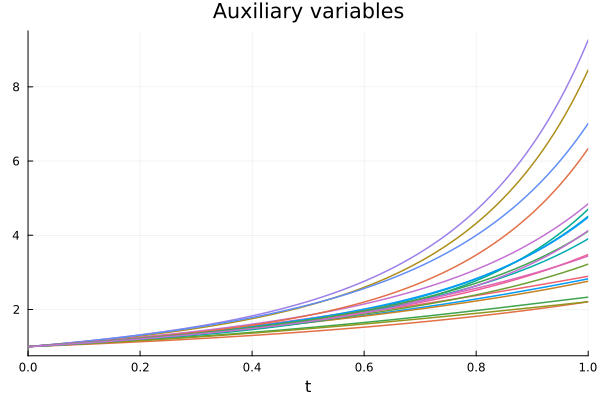

In [35]:
plot(sol, idxs=(N+1):2N, plotdensity=100, lw=1.5, title="Auxiliary variables", legend=false)

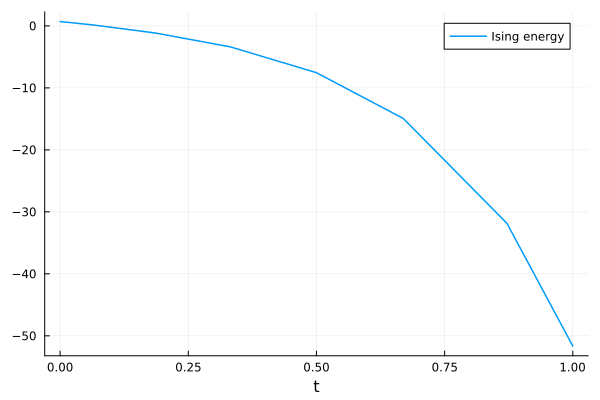

In [36]:
plot(sol.t, [ x_t[1:N]'*(J * x_t[1:N]) for x_t in sol.u], label="Ising energy", lw=1.5, xlabel="t")

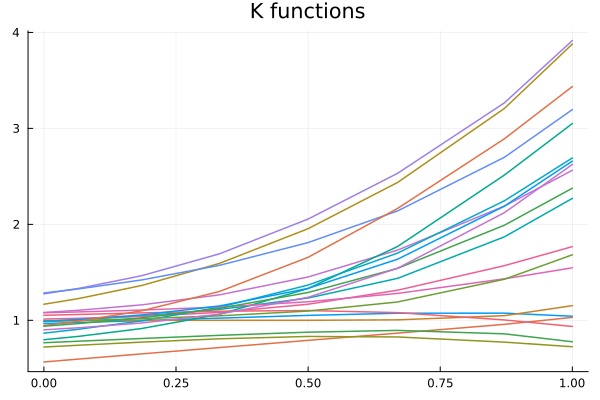

In [38]:
# Preallocate the array for K
K_values = zeros(length(sol.t), N)

# Compute K for each time instance
for (i, u) in enumerate(sol.u)
    x = u[1:N]
    h = [sum(J[i, j] * x[j] for j in 1:N) for i in 1:N]
    # K ALGO2
    K = [1 - tanh(h[i]) * x[i] for i in 1:N]    
    K_values[i, :] = K
end

# Plot each component of K over time
p = plot()
for i in 1:N
    plot!(p, sol.t, K_values[:, i], label="K$i", lw=1.5, legend=false, title="K functions")
end

# Show the plot
display(p)

TODO:
- Displacement and truncation of the $K$ when $h$ is saturated or $x$ is at a corner of the hyper cube $\pm \varepsilon$

# Algo 3

## The update rule

### EoM:
$$
\frac{dx_i}{dt} = P_{\text{box}}\left[ a F(x_i) - G\left( \sum_j e_{ij} h_i \right) \right]
$$

$$
\frac{de_{ij}}{dt} = e_{ij} K_i K_j
$$

In [4]:
function F(x_i, p)
    return (p-1)*x_i-x_i^3
end

function G(x)
    return x
end

function P(dx_i, x_i)
    dx_projected = dx_i
    if x_i >= 1 && dx_i >= 0.0
        dx_projected = 0.0
    end
    if x_i <= -1 && dx_i <= 0.0
        dx_projected = 0.0
    end

    return dx_projected
end


function ALGO3_rule!(du, u, params, t)
    p = params[1]
    a = params[2]
    b = params[3]
    N = params[4]
    J = params[5]

    x = u[1:N]
    e = reshape(u[(N+1):end], N, N)

    h = [sum(J[i, j]*x[j] for j in 1:N) for i in 1:N]
    K = [1-tanh(h[i])*x[i] for i in 1:N]

    
    for i in 1:N
        du[i]   = P( a * F(x[i], p) - G( sum([ e[i, j]* h[j] for j in 1:N]) ), x[i])
        for j in 1:N
            flat_idx = N + (i - i) * N + j
            du[flat_idx] = e[i, j] * K[i] * K[j]
        end
    end
end

ALGO3_rule! (generic function with 1 method)

## Simulation & plottinhg

In [5]:
# define problem and run simulation
params = (1.9, 1.0, 0.1, N, J)     # (p, a, b, N, J)
tspan = (0.0,150.0)

# initial condition(s)
u0 = rand(N+N*N)
u0[1:N] = 0.95*(2*rand(N)-ones(N))   # This is x(t=0)
#u0[N:] = ones(N*N);              # This is e(t=0)

#p, beta, alpha, N J
prob = ODEProblem(ALGO3_rule!, u0, tspan, params)
sol = solve(prob, Tsit5());

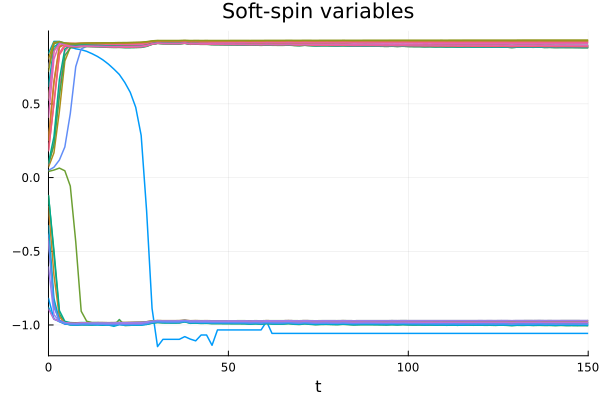

In [6]:
plot(sol, idxs=1:N, plotdensity=100, lw=1.5, title="Soft-spin variables", legend=false)

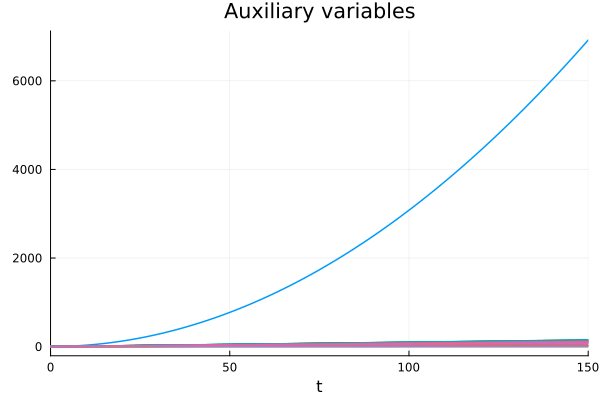

In [7]:
plot(sol, idxs=(N+1):2N, plotdensity=100, lw=1.5, title="Auxiliary variables", legend=false)

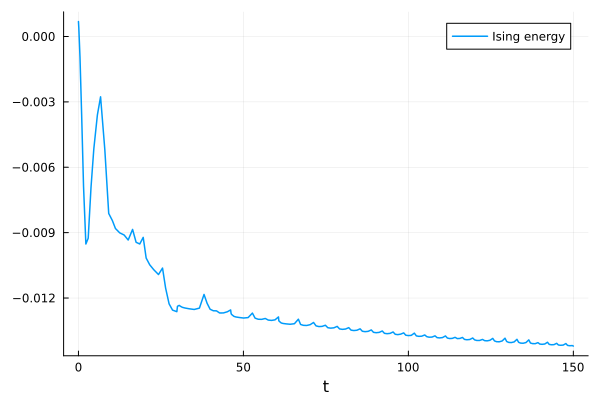

In [8]:
plot(sol.t, [ x_t[1:N]'*(J * x_t[1:N]) for x_t in sol.u], label="Ising energy", lw=1.5, xlabel="t")

# Algo 4

## The update rule

### EoM:
$$
\frac{dx_i}{dt} = a F(x_i) - e_i \partial_i \sum_m K_m = a F(x_i) - e_i\left( \sum_m \frac{J_{mi}}{h_m^{\text{max}} - h_m^{\text{min}}} \right)
$$

$$
\frac{de_i}{dt} = e_i K_i
$$

In [20]:
function F(x_i, p)
    return (p-1)*x_i-x_i^3
end

function boxed(x)
    N = length(x)
    result = zeros(N)
    for i in 1:N
        if x[i] > 1.0
            result[i] = 1.0
        elseif x[i] < -1.0
            result[i] = -1.0
        else
            result[i] = x[i]
        end
    end
    return result
end

function ALGO4_rule!(du, u, params, t)
    p = params[1]
    a = params[2]
    b = params[3]
    N = params[4]
    J = params[5]
    h_min = params[6]
    h_max = params[7]

    x = u[1:N]
    x = boxed(x)
    e = u[N+1:2N]

    h = [sum(J[i, j]*x[j] for j in 1:N) for i in 1:N]
    K = [(h[i]-h_min[i])/(h_max[i]-h_min[i]) for i in 1:N]

    for i in 1:N
        du[i]   = a * F(x[i], p) - e[i] * h[i]*sum( J[m, i]/(h_max[m]-h_min[m]) for m in 1:N) 
        du[i+N] = e[i]*K[i]
    end
end

ALGO4_rule! (generic function with 1 method)

## Simulation and plotting

In [25]:
# define problem and run simulation
h_min = [sum(- J[i, j] for j in 1:N) for i in 1:N]
h_max = [sum(J[i, j] for j in 1:N) for i in 1:N]
params = (1.9, 1.0, 0.1, N, J, h_min, h_max)     # (p, a, b, N, J)
tspan = (0.0,10.0)

# initial condition(s)
u0 = rand(N+N*N)
u0[1:N] = 0.95*(2*rand(N)-ones(N))   # This is x(t=0)
#u0[N:] = ones(N*N);              # This is e(t=0)

#p, beta, alpha, N J
prob = ODEProblem(ALGO4_rule!, u0, tspan, params)
sol = solve(prob, Tsit5());



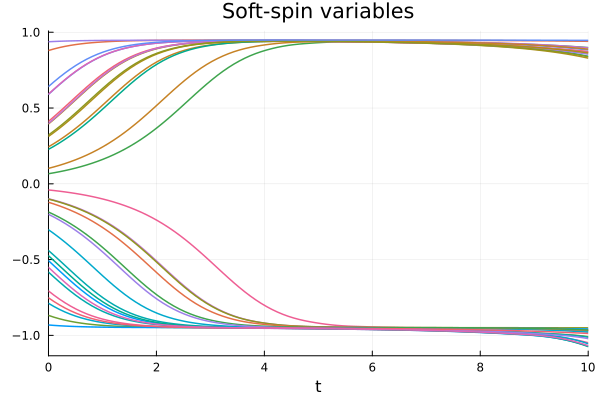

In [26]:
plot(sol, idxs=1:N, plotdensity=100, lw=1.5, title="Soft-spin variables", legend=false)

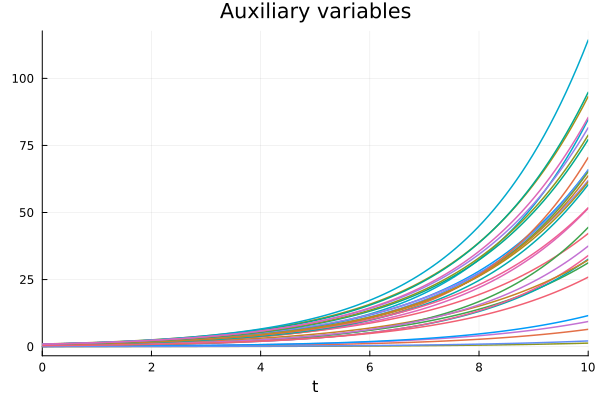

In [27]:
plot(sol, idxs=(N+1):2N, plotdensity=100, lw=1.5, title="Auxiliary variables", legend=false)

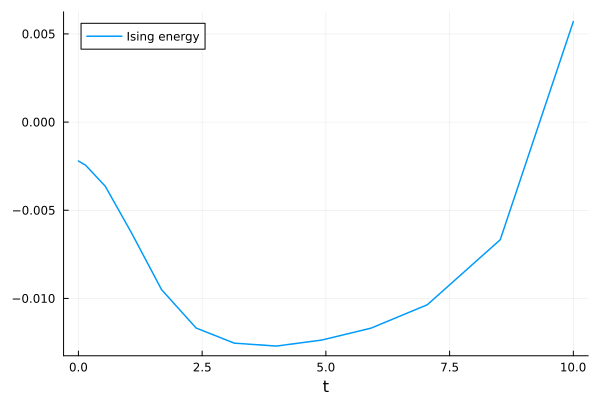

In [28]:
plot(sol.t, [ x_t[1:N]'*(J * x_t[1:N]) for x_t in sol.u], label="Ising energy", lw=1.5, xlabel="t")

### Derivation

where
$$h_i = \sum_j J_{ij}x_j$$
and
$$K_m = \frac{h_m - h_m^{\text{min}}}{h_m^{\text{max}} - h_m^{\text{min}}}$$
and
$$
F(x_i) = (p-1)x_i -x_i^3
$$

For the sum
$$
\partial_i \sum_m K_m = \sum_m \frac{1}{h_m^{\text{max}} - h_m^{\text{min}}} \underbrace{\sum_j J_{mj} \delta_{ij}}_{=\partial_i h_m}= \sum_m \frac{J_{mi}}{h_m^{\text{max}} - h_m^{\text{min}}}
$$

# Algo 5

## Update rule

### EoM:
$$
\frac{dx_i}{dt} = a F(x_i) - e_i \partial_i \sum_m K_m = a F(x_i) - e_i\left( \sum_m \frac{J_{mi}}{h_m^{\text{max}} - h_m^{\text{min}}} \right)
$$

$$
\frac{de_i}{dt} = e_i K_i
$$

In [48]:
function F(x_i, p)
    return (p-1)*x_i-x_i^3
end

function boxed(x)
    N = length(x)
    result = zeros(N)
    for i in 1:N
        if x[i] > 1.0
            result[i] = 1.0
        elseif x[i] < -1.0
            result[i] = -1.0
        else
            result[i] = x[i]
        end
    end
    return result
end

function K_fnc(h::Float64, h_min::Float64, h_max::Float64)::Float64
    if h < h_min
        return 0.0
    elseif h > h_max
        return 1.0
    else
        return (h - h_min) / (h_max - h_min)
    end
end

function ALGO5_rule!(du, u, params, t)
    p = params[1]
    a = params[2]
    b = params[3]
    N = params[4]
    J = params[5]
    lambda = params[6]
    h_min  = params[7]
    h_max  = params[8]

    x = u[1:N]
    e = u[N+1:2N]

    h = [sum(J[i, j]*x[j] for j in 1:N) for i in 1:N]
    K = [K_fnc(h[i], h_min[i], h_max[i]) for i in 1:N]

    for i in 1:N
        du[i]   = e[i] *( a * F(x[i], p) - sum( J[m, i]/(h_max[m]-h_min[m]) for m in 1:N) )
        du[i+N] = e[i]*(K[i] - lambda*log(e[i]))
    end
end

ALGO5_rule! (generic function with 1 method)

## Simulation and plotting

In [ ]:
h_min_values = get_hmin(J)
h_max_values = get_hmax(J)

In [72]:
# define problem and run simulation
params = (0.9, 1.0, 0.1, N, J, 0.01, h_min_values, h_max_values)     # (p, a, b, N, J)
tspan = (0.0,18.0)

# initial condition(s)
u0 = rand(N+N*N)
u0[1:N] = 0.95*(2*rand(N)-ones(N))   # This is x(t=0)
#u0[N:] = ones(N*N);              # This is e(t=0)

#p, beta, alpha, N J
prob = ODEProblem(ALGO5_rule!, u0, tspan, params)
sol = solve(prob, Tsit5());

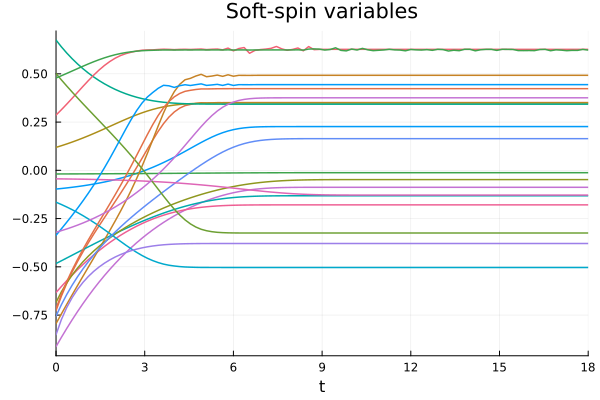

In [73]:
plot(sol, idxs=1:N, plotdensity=100, lw=1.5, title="Soft-spin variables", legend=false)

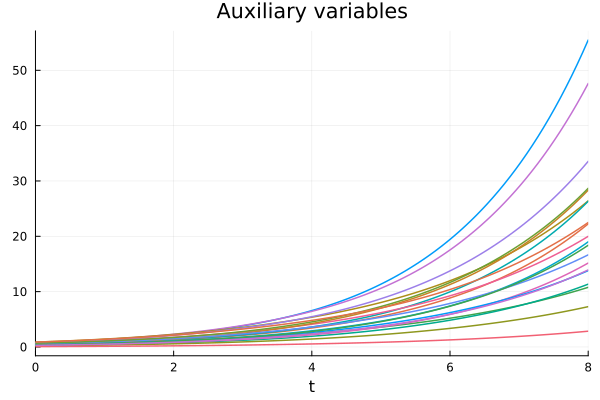

In [66]:
plot(sol, idxs=(N+1):2N, plotdensity=100, lw=1.5, title="Auxiliary variables", legend=false)

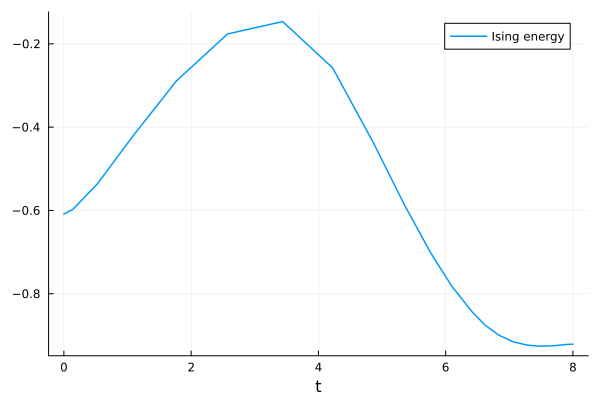

In [67]:
plot(sol.t, [ x_t[1:N]'*(J * x_t[1:N]) for x_t in sol.u], label="Ising energy", lw=1.5, xlabel="t")

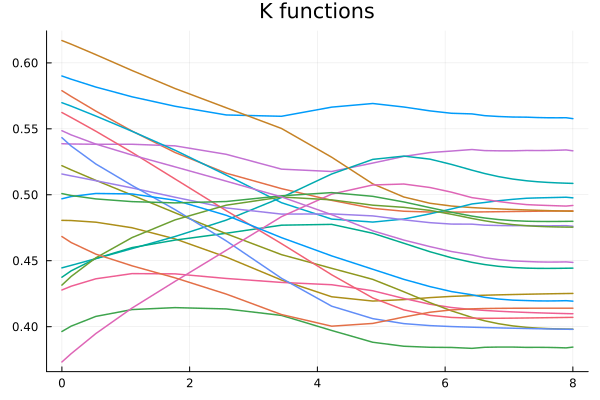

In [71]:
# Preallocate the array for K
K_values = zeros(length(sol.t), N)

# Compute K for each time instance
for (i, u) in enumerate(sol.u)
    x = u[1:N]
    h = [sum(J[i, j] * x[j] for j in 1:N) for i in 1:N]
    # K ALGO2
    K = [K_fnc(h[i], h_min_values[i], h_max_values[i]) for i in 1:N]    
    K_values[i, :] = K
end

# Plot each component of K over time
p = plot()
for i in 1:N
    plot!(p, sol.t, K_values[:, i], label="K$i", lw=1.5, legend=false, title="K functions")
end

# Show the plot
display(p)

# Leftowers

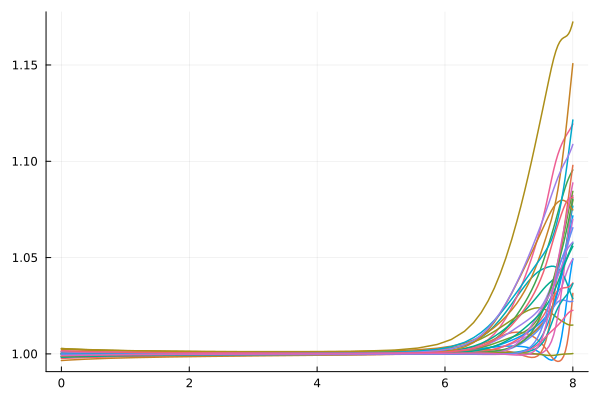

In [13]:
# Preallocate the array for K
K_values = zeros(length(sol.t), N)

# Compute K for each time instance
for (i, u) in enumerate(sol.u)
    x = u[1:N]
    h = [sum(J[i, j] * x[j] for j in 1:N) for i in 1:N]
    h_min = [sum(- J[i, j] for j in 1:N) for i in 1:N]
    h_max = [sum(J[i, j] for j in 1:N) for i in 1:N]

    # K ALGO2
    K = [1 - tanh(h[i]) * x[i] for i in 1:N]

    # K ALGO3
    #K = [1 - tanh(h[i]) * x[i] for i in 1:N]
    #K = [1 - tanh(h[i]) for i in 1:N]
    #K = K - ones(N)*minimum(K)
    #K = K*(1/maximum(K))
    
    # K ALGO4
    #K = [(h[i]-h_min[i])/(h_max[i]-h_min[i]) for i in 1:N]
    
    
    K_values[i, :] = K
end

# Plot each component of K over time
p = plot()
for i in 1:N
    plot!(p, sol.t, K_values[:, i], label="K$i", lw=1.5, legend=false)
end

# Show the plot
display(p)

$$
\frac{dx_i}{dt} = a F(x_i) - e_i \partial_i \sum_m K_m = a F(x_i) - e_i\left( \frac{K_i-1}{x_i} - h_i \sum_m \frac{1}{\text{ch}^2(h_m)} \right)
$$

### Derivation

where
$$h_i = \sum_j J_{ij}x_j$$
and
$$K_i = 1-\sigma(h_i) x_i$$
and
$$
F(x_i) = (p-1)x_i -x_i^3
$$

$$
\partial_i K_m = \underbrace{- \sigma\left( h_m \right)}_{-\frac{1-K_m}{x_m}} \overbrace{\partial_i x_m}^{= \delta_{im}} - x_m \partial_i \sigma \left( h_m \right)
$$
$$
\partial_i K_m = -\delta_{im} \frac{1-K_m}{x_m} - x_m \sigma'(h_m)  \underbrace{\partial_i h_m}_{=\sum_j J_{mj} \delta_{ij}}
$$
if $\sigma \equiv \text{tanh}$ we have 
$$
\partial_i K_m = -\delta_{im} \frac{1-K_m}{x_m} - \frac{x_m}{\text{ch}^2(h_m)} J_{mi} 
$$
For the sum
$$
\sum_m \partial_i K_m = \frac{K_i-1}{x_i} + h_i \sum_m - \sigma'(h_m)
$$